# Feature Engineering Notebook

The data was retrieved from UCI machine learning reporsitory and loaded on IBM cloud opbject storage. The link is given below.
https://archive.ics.uci.edu/ml/datasets/Combined+Cycle+Power+Plant
The schema definition from UCI repository is given below:

AT = Atmospheric Temperature in C
 V = Exhaust Vacuum Pressure
AP = Atmospheric Pressure
RH = Relative Humidity
PE = Power Output. This is the value we are trying to forecast from the parameters given above.

In [1]:
# The code was removed by Watson Studio for sharing.

Waiting for a Spark session to start...
Spark Initialization Done! ApplicationId = app-20200615151857-0000
KERNEL_ID = 6255af89-9d5e-4ba2-972b-e5f5950144ee


,AT,V,AP,RH,PE
0,14.96,41.76,1024.07,73.17,463.26
1,25.18,62.96,1020.04,59.08,444.37
2,5.11,39.40,1012.16,92.14,488.56
3,20.86,57.32,1010.24,76.64,446.48
4,10.82,37.50,1009.23,96.62,473.90


Change the column names to be more representative for the data for enviornmental conditions.

# Correlation matrix for feature engineering

In [15]:
df.corr()

,AtmTemperature,ExhaustV,AtmPressure,RelHumidity,PowerOut
AtmTemperature,1.000000,0.844107,-0.507549,-0.542535,-0.948128
ExhaustV,0.844107,1.000000,-0.413502,-0.312187,-0.869780
AtmPressure,-0.507549,-0.413502,1.000000,0.099574,0.518429
RelHumidity,-0.542535,-0.312187,0.099574,1.000000,0.389794
PowerOut,-0.948128,-0.869780,0.518429,0.389794,1.000000


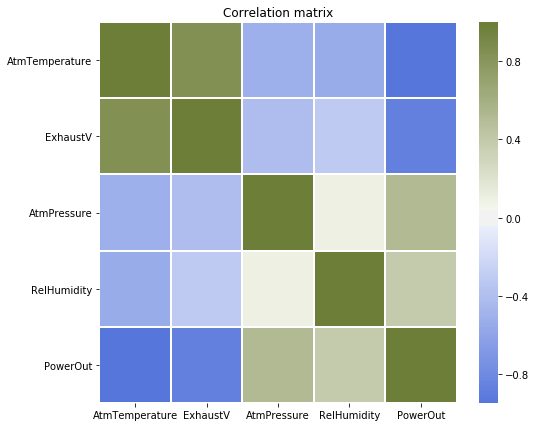

In [9]:
import requests 
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
# Plotting correlation matrix
def coll_plot(df, title):
    corr = df.corr()
    mask = np.zeros_like(corr, dtype=np.bool)
    mask[np.triu_indices_from(mask)] = False
    f, ax = plt.subplots(figsize=(8, 7))
    plt.title(title)
    cmap = sns.diverging_palette(-100, 100, as_cmap=True)
    sns.heatmap(corr, mask=mask, cmap=cmap, vmax=1, center=0, linewidths=1)
    
coll_plot(df, 'Correlation matrix')

Correlation matrix shows that Ambient temperature and exhaust vacuum are strongly linearly related to each other and to the power output, while Atmospheric pressure and relative humidity have weak linear relations to all other variables and output. Therefore, ambient temperature and exhaust vacuum pressure are considered governing variables (i.e. these two as input features). The atmospheric pressure correlates stronger with the plant power output that also defines an features variation. The effect of absence and presence of each of variable on regression modeling can be studied by feature engineering. Therefore models (or pipelines for models) were created with all four independent variables as input features, 3 independent variables (ambient temperature,  exhaust vacuum pressure, and atmospheric pressure) as input features and two independent variables (ambient temperature and exhaust vacuum pressure) as input features. The process of building pipelines will be discussed in more detail in the modeling section.

In [2]:
# renaming column names
df.rename(columns={'AT': 'AtmTemperature', 'V': 'ExhaustV', 'AP': 'AtmPressure', 'RH': 'RelHumidity', 'PE': 'PowerOut'}, inplace=True)
df.head()

,AtmTemperature,ExhaustV,AtmPressure,RelHumidity,PowerOut
0,14.96,41.76,1024.07,73.17,463.26
1,25.18,62.96,1020.04,59.08,444.37
2,5.11,39.40,1012.16,92.14,488.56
3,20.86,57.32,1010.24,76.64,446.48
4,10.82,37.50,1009.23,96.62,473.90


Remove the "NaN" or non-existent values colums. Forst check the number of "NaN" values in each column

In [3]:
print("Number of NaN values for the column temperature :", df['AtmTemperature'].isnull().sum())
print("Number of NaN values for the column exhaust_vacuum :", df['ExhaustV'].isnull().sum())
print("Number of NaN values for the column ambient_pressure :", df['AtmPressure'].isnull().sum())
print("Number of NaN values for the column relative_humidity :", df['RelHumidity'].isnull().sum())
print("Number of NaN values for the column energy_output :", df['PowerOut'].isnull().sum())

Number of NaN values for the column temperature : 0
Number of NaN values for the column exhaust_vacuum : 0
Number of NaN values for the column ambient_pressure : 0
Number of NaN values for the column relative_humidity : 0
Number of NaN values for the column energy_output : 0


Since total number of "NaN" values is zero in each column, the removal of non-existent values is not required.
Now, split the data frame to train and test data frames.

In [3]:
#Applying IQR score method to remove outliers
Q1 = df.quantile(0.25)
Q3 = df.quantile(0.75)
IQR = Q3 - Q1
print(IQR)

AtmTemperature    12.2100
ExhaustV          24.8000
AtmPressure        8.1600
RelHumidity       21.5025
PowerOut          28.6800
dtype: float64


In [4]:
df2 = df[~((df < (Q1 - 1.5 * IQR)) |(df > (Q3 + 1.5 * IQR))).any(axis=1)]
df2.shape

(9468, 5)

In [10]:
#Splitting the data into test and train datasets
from sklearn.model_selection import train_test_split

train, test = train_test_split(df2, test_size=0.2)

In [6]:
train.head()

,AtmTemperature,ExhaustV,AtmPressure,RelHumidity,PowerOut
2315,14.50,39.00,1017.04,75.75,465.32
3518,23.66,60.37,1006.91,87.13,438.59
7565,14.57,44.45,1021.42,66.23,462.48
4883,32.84,68.14,1003.59,43.88,425.18
9143,13.69,41.74,1021.19,60.86,471.84


In [7]:
test.head()

,AtmTemperature,ExhaustV,AtmPressure,RelHumidity,PowerOut
347,28.29,68.67,1005.46,69.22,436.40
9014,13.42,40.92,1022.84,75.89,458.49
8086,5.42,41.38,1020.77,86.02,491.38
5493,21.31,58.66,1012.67,69.36,451.96
2585,31.10,68.51,1012.99,54.30,428.68


Now, load test and train data to Spark for data modeling and evaluation

In [11]:
from pyspark.sql import SQLContext
sqlContext = SQLContext(sc)

In [12]:
trainspark_df = sqlContext.createDataFrame(train)
testspark_df = sqlContext.createDataFrame(test)

In [13]:
trainspark_df.show(5)

+--------------+--------+-----------+-----------+--------+
|AtmTemperature|ExhaustV|AtmPressure|RelHumidity|PowerOut|
+--------------+--------+-----------+-----------+--------+
|         23.85|   72.43|    1008.01|      88.34|  439.02|
|         19.12|   45.01|     1014.0|      59.95|  453.24|
|         31.68|   74.16|     1011.3|      55.94|  434.61|
|         19.44|   39.53|    1006.99|      63.18|  457.09|
|         12.32|   43.69|    1016.26|      83.18|   471.6|
+--------------+--------+-----------+-----------+--------+
only showing top 5 rows



In [11]:
testspark_df.show(5)

+--------------+--------+-----------+-----------+--------+
|AtmTemperature|ExhaustV|AtmPressure|RelHumidity|PowerOut|
+--------------+--------+-----------+-----------+--------+
|         28.29|   68.67|    1005.46|      69.22|   436.4|
|         13.42|   40.92|    1022.84|      75.89|  458.49|
|          5.42|   41.38|    1020.77|      86.02|  491.38|
|         21.31|   58.66|    1012.67|      69.36|  451.96|
|          31.1|   68.51|    1012.99|       54.3|  428.68|
+--------------+--------+-----------+-----------+--------+
only showing top 5 rows



## Features and Piplelines

In [17]:
# Create input features and forecast column
from pyspark.ml.feature import VectorAssembler

vectorizer = VectorAssembler()
vectorizer3 = VectorAssembler()
vectorizer2 = VectorAssembler()
# all 4 parameters as input features
vectorizer.setInputCols(["AtmTemperature", "ExhaustV", "AtmPressure", "RelHumidity"])
#  3 parameters as input features
vectorizer3.setInputCols(["AtmTemperature", "ExhaustV", "AtmPressure"])
# 2 parameters as input features
vectorizer2.setInputCols(["AtmTemperature", "ExhaustV"])
vectorizer.setOutputCol("features")
vectorizer3.setOutputCol("features")
vectorizer2.setOutputCol("features")

VectorAssembler_bf2320780874

In [21]:
# pipelines with different features for linear regression

from pyspark.ml.regression import LinearRegression
from pyspark.ml import Pipeline

# Initialize linear regression learner
lr = LinearRegression()

# Setting the parameters for the method
lr.setPredictionCol("Forecast_PowerOut")\
  .setLabelCol("PowerOut")\
  .setFeaturesCol("features")\
  .setMaxIter(100)\
  .setRegParam(0.1)\
  .setElasticNetParam=0.8
    
lrPipeline = Pipeline()
lrPipeline3 = Pipeline()
lrPipeline2 = Pipeline()
lrPipeline.setStages([vectorizer, lr])
lrPipeline3.setStages([vectorizer3, lr])
lrPipeline2.setStages([vectorizer2, lr])

Pipeline_e11b7f49b488

In [22]:
# pipelines with different features for random forest regressor
from pyspark.ml.regression import RandomForestRegressor

# Creating a RandomForestRegressor
rf = RandomForestRegressor()

rf.setLabelCol("PowerOut")\
  .setPredictionCol("Forecast_PowerOut")\
  .setFeaturesCol("features")\
  .setSeed(100088121)\
  .setMaxDepth(10)\
  .setNumTrees(40)

# Creating a Pipelines for randome forest regressor
rfPipeline = Pipeline()
rfPipeline3 = Pipeline()
rfPipeline2 = Pipeline()
# Setting the stages of the Pipeline
rfPipeline.setStages([vectorizer, rf])
rfPipeline3.setStages([vectorizer3, rf])
rfPipeline2.setStages([vectorizer2, rf])

Pipeline_f85f39dabe10

In [23]:
# pipelines with different features for Decision tree regressor

from pyspark.ml.regression import DecisionTreeRegressor
from pyspark.ml import Pipeline


# Creating a DecisionTreeRegressor
dt = DecisionTreeRegressor()

dt.setLabelCol("PowerOut")\
  .setPredictionCol("Forecast_PowerOut")\
  .setFeaturesCol("features")\
  .setSeed(100088121)\
  .setMaxBins(120)

# Creating Pipelines for decision tree regressors
dtPipeline = Pipeline()
dtPipeline3 = Pipeline()
dtPipeline2 = Pipeline()

# Setting the stages of the Pipeline
dtPipeline.setStages([vectorizer, dt])
dtPipeline3.setStages([vectorizer3, dt])
dtPipeline2.setStages([vectorizer2, dt])

Pipeline_ec70ed242a4d